# Keplerian+GP fit 

In [117]:
import os
import pprint
import copy
import corner
import emcee
import matplotlib.pyplot as plt
import numpy as np
from george.gp import LinAlgError
import yaml
from matplotlib import cm
import rv_analysis_tools as rv
import importlib
importlib.reload(rv)
from astropy.timeseries import LombScargle
import dynesty
import radvel
import pickle

## Target selection

In [118]:
print('Welcome to the joint RV analysis tool!')
print('Which star would you like to analyze?')

star = input('Enter star name:')

print('Loading input file and data...')

# Read input file
try: 
    with open(f'CRAPresults/{star}/input.yaml', 'r') as file:
        yaml_file = yaml.safe_load(file)
except FileNotFoundError:
    print('This star does not exist in the database.')
    raise

Welcome to the joint RV analysis tool!
Which star would you like to analyze?
Loading input file and data...


In [119]:
model_to_run = 'keplerian_only'

Loading data

In [120]:
data = rv.DataLoader(yaml_file)
i_shared = data.activity_priors['shared_params']

shared_params_str = rv.create_shared_params_str(i_shared)
nplanets_str = rv.create_nplanets_str(data.nplanets)
ecc_str = rv.create_fit_ecc_str(data.fit_ecc)

dir_template = "{parent_dir}/{star}/{crap_dir}/{model_to_run}/{shared_param}/{nplanet}/{fit_ecc}/{sampler}/"

#Create the working path
working_path = f'CRAPresults/{star}/CRAPanalysis/{model_to_run}/{nplanets_str}/{ecc_str}/{data.sampler}/'

# Create the directory
os.makedirs(working_path, exist_ok=True)

# Define GP labels
gp_labels = rv.generate_param_names(['mu', 'log_wn', 'log_amp', 'log_lambda', 'gamma', 'log_Prot'],
                                    i_shared, data.instruments)
print('Done.')

Done.


In [121]:
for instrument in data.instruments: 
    data.y_rv[instrument] -= np.mean(data.y_rv[instrument])

Numbers of GP parameters

In [122]:
n_gp_params = 6

Matplotlib prefererences

In [123]:
# Styling parameters
plt.style.use('ggplot')
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'legend.fontsize': 'small',
    'axes.labelsize': 'medium',
    'axes.titlesize':'large',
    'xtick.labelsize':'small',
    'ytick.labelsize':'small',
    'figure.autolayout': True,
})

colors = plt.cm.jet(np.linspace(1, 0, len(data.instruments)))

Periodogram

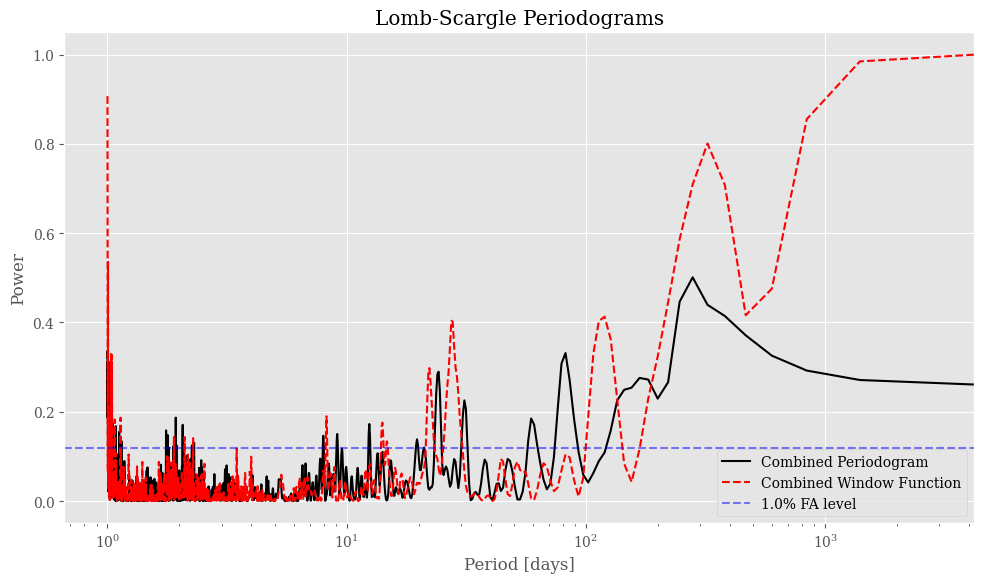

In [124]:
rv.plot_lombscargle_periodograms(data.t_rv, data.y_rv, data.yerr_rv, combined = True, file_path = working_path+'RV_periodogram.png')

Creating the priors and the initial guess 

In [125]:
print(f'Creating initial guess for the RV parameters for {data.nplanets} planets ...')

# Initialize lists to hold planet parameters and labels
p0 = []
planet_labels = []
priors = {}  # Dictionary to store the priors


# Loop over the number of planets to construct the parameter and label lists
for i in range(1, data.nplanets+ 1):
    if data.n_planet_params == 3: 
        p0.extend([
            data.RV_priors[f'per{i}']['guess'],
            data.RV_priors[f'tc{i}']['guess'],
            data.RV_priors[f'k{i}']['guess']
        ])
        planet_labels.extend([f'per{i}', f'tc{i}', f'k{i}'])
    else: 
        p0.extend([
            data.RV_priors[f'per{i}']['guess'],
            data.RV_priors[f'tc{i}']['guess'],
            data.RV_priors[f'e{i}']['guess'],
            data.RV_priors[f'w{i}']['guess'],
            data.RV_priors[f'k{i}']['guess']
        ])
        planet_labels.extend([f'per{i}', f'tc{i}', f'e{i}', f'w{i}', f'k{i}'])

priors = data.RV_priors
# Create initial parameter vector: 
p0_vect = rv.params_vector(p0, data.instruments, i_shared, num_planets=data.nplanets, n_planet_params=data.n_planet_params)
comb_p0 = p0_vect.p
param_labels = planet_labels

# Save the priors to a file
with open(working_path + 'RV_priors.yaml', 'w') as file:
    yaml.dump(priors, file)


Creating initial guess for the RV parameters for 3 planets ...


Creating the model

In [126]:
print('Creating Keplerian model...')
model = rv.Planet_Model(comb_p0, data,
                        num_planets = data.nplanets,
                        n_planet_params = data.n_planet_params)
print('Done.')

Creating Keplerian model...
Done.


Look at first guess

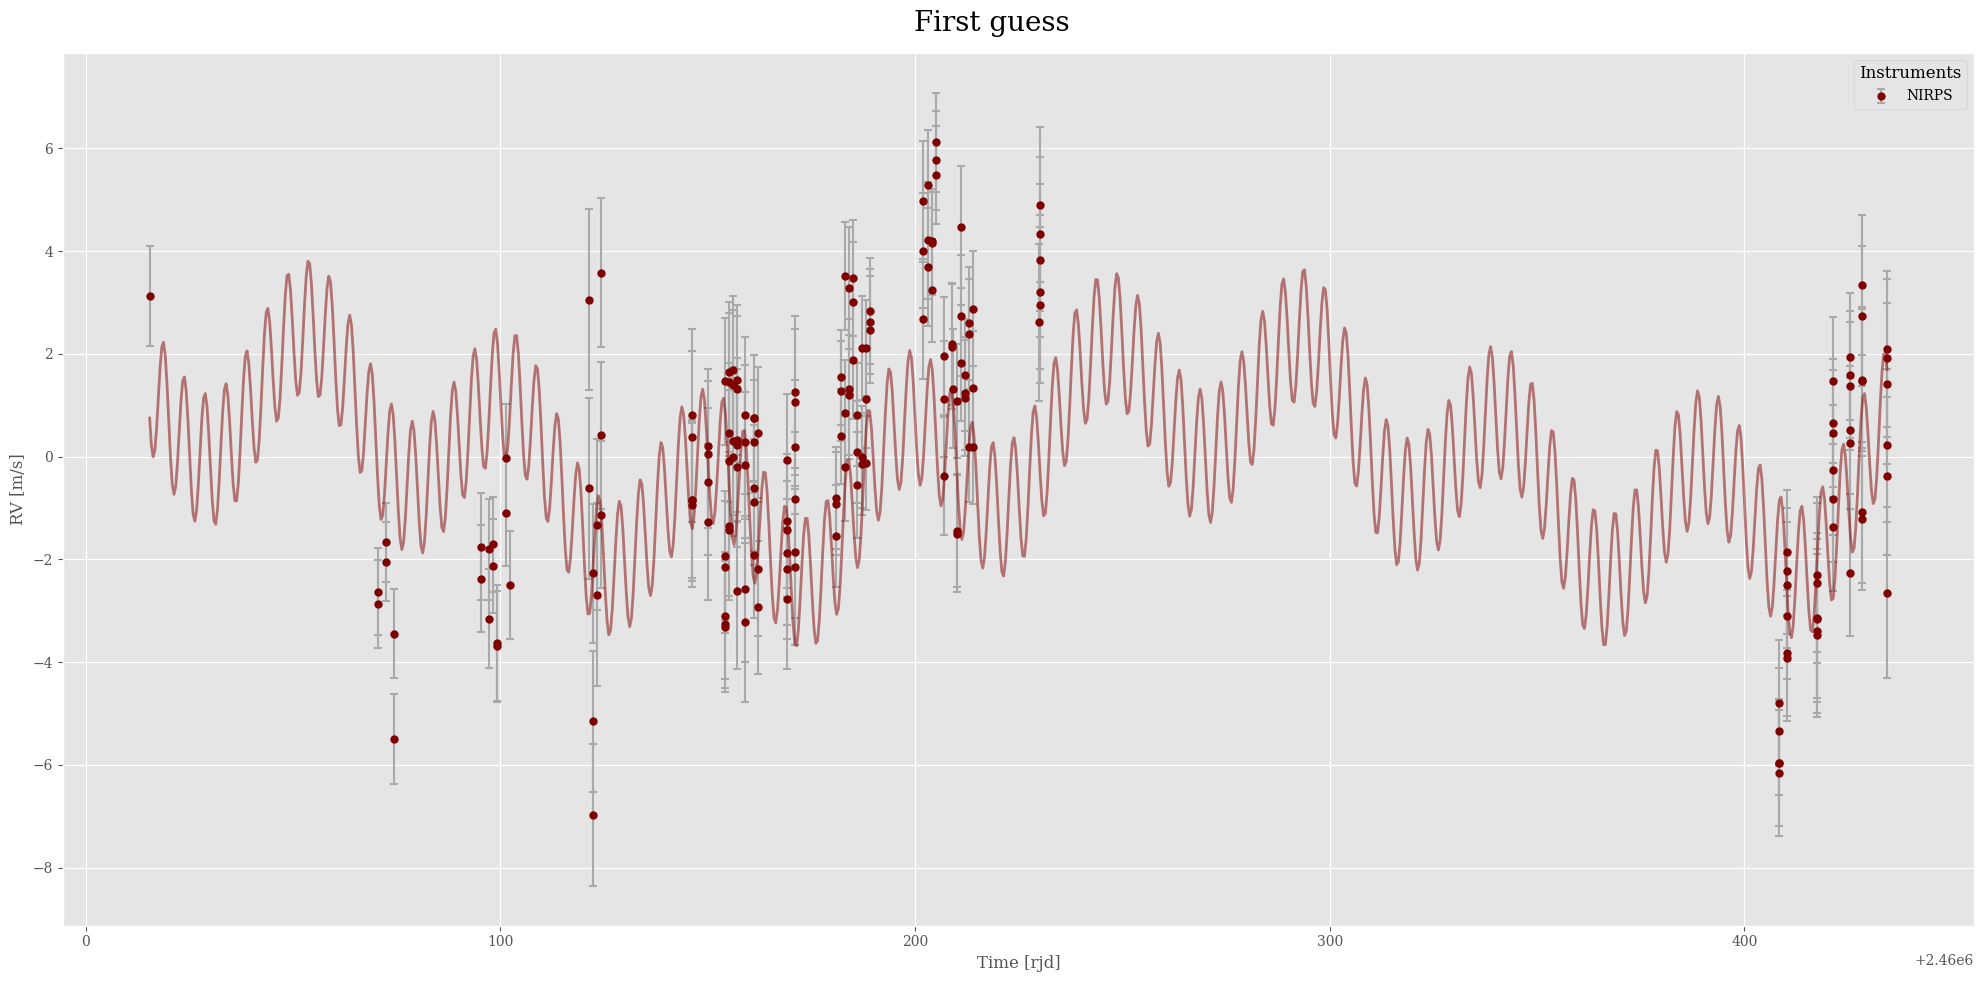

In [127]:
# Plot the RV data and the first guess
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    
for idx, instrument in enumerate(data.instruments):
    # Subtler error bars
    ax.errorbar(data.t_rv[instrument], data.y_rv[instrument], yerr=data.yerr_rv[instrument], fmt='o', 
                label=instrument, color=colors[idx], 
                ecolor='darkgray', elinewidth=1.5, capsize=3, capthick=1.5)
    
    ax.plot(data.t_mod[instrument], model.predict(data.t_mod[instrument]), color=colors[idx], lw=2, alpha = 0.5)
    
    ax.set_xlabel('Time [rjd]')
    ax.set_ylabel('RV [m/s]')
    
    ax.legend(title='Instruments')
plt.suptitle('First guess', fontsize=20)
plt.show()
    

## Run `emcee`

### Creating a combined parameter vector to use in the MCMC run
This is necessary because we want the shared GP parameters to be updated for all instruments at once.

In [128]:
if data.sampler == "emcee":
    # MCMC fit of the GP hyperparameters 
    nwalkers, ndim = 3*len(comb_p0), len(comb_p0)
    num_warmup = 50 * ndim
    num_post_samples = 500 * ndim

    
    sampler = emcee.EnsembleSampler(
            nwalkers,
            ndim,
            rv.emcee_log_post_planet_only,
            args=(model, priors, data.nplanets, data.n_planet_params),
            moves=[emcee.moves.DEMove()]
        )
    # Change the dimension of p0 with the number of walkers
    comb_p0_emcee = np.array([comb_p0 + np.random.randn(ndim) * 1e-4 for i in range(nwalkers)])

    if data.run_RV == True:
        print('Running MCMC for the combined model...')
        sampler.run_mcmc(comb_p0_emcee, num_post_samples + num_warmup, progress=True) # Run the MCMC
        
        # Save the samples
        post_samples_walkers = sampler.get_chain(discard=num_warmup)
        post_samples = post_samples_walkers.reshape(-1, post_samples_walkers.shape[2]) # Remove the walkers dimension
        np.save(working_path + 'post_samples_walkers.npy', post_samples_walkers)
        np.save(working_path + 'post_samples.npy', post_samples)  
        
        # Save the log probabilities
        log_prob_samples = sampler.get_log_prob(discard=num_warmup)
        np.save(working_path + 'log_prob_samples.npy', log_prob_samples) 
        
        # Compute the BIC value
        N_data_points = np.sum([len(data.t_rv[instrument]) for instrument in data.instruments])
        bic = rv.bic_calculator(np.max(log_prob_samples), ndim, N_data_points)
        np.savetxt(working_path + f'BIC.txt',
                   np.array([bic]), fmt='%.6f')
        print(f'BIC: {bic}')
        
        print('Done.')
        
    else: 
        print('Loading previous MCMC fit for the combined model...')

Running MCMC for the combined model...


  0%|          | 0/4950 [00:00<?, ?it/s]

100%|██████████| 4950/4950 [03:05<00:00, 26.72it/s]


BIC: 865.0741434334725
Done.


## Run `dynesty`

In [129]:
if data.sampler == 'dynesty': 
    # Set up the Nested Sampler
    ndim = len(comb_p0)

    # Define parameters in relation to ndim
    n_live_points = 10 * ndim  # Number of live points, typically 10 * ndim
    dlogz = 0.1  # Stopping criteria for the evidence
    maxiter = 5000 * ndim  # Maximum number of iterations
    num_warmup = 100 * ndim

    if data.run_RV: 
        sampler = dynesty.NestedSampler(rv.dynesty_log_likelihood_planet_only, rv.dynesty_prior_transform_planet_only, ndim, 
                                        nlive=n_live_points, 
                                        logl_args=(model,), 
                                        ptform_args=(priors, model, data, data.nplanets, data.n_planet_params))

        # Run the Nested Sampler
        sampler.run_nested(dlogz=dlogz, maxiter=maxiter)
        results = sampler.results
        # Save the results to a .pkl file
        with open(working_path + 'dynesty_results.pkl', 'wb') as f:
            pickle.dump(results, f)
        
        all_log_prob_samples = results.logl
        
        # Smooth the log-probability curve using a moving average
        window_size = 50
        smoothed_log_prob = np.convolve(all_log_prob_samples, np.ones(window_size)/window_size, mode='valid')

        # Calculate the derivative of the smoothed log-probability
        derivative_log_prob = np.diff(smoothed_log_prob)

        # Identify the point where the derivative falls below a threshold and stays there
        threshold = 0.01
        burn_in = next((i for i, v in enumerate(derivative_log_prob) if v < threshold), 0) + window_size

        print(f"Determined burn-in period: {burn_in}")

        # Gather the results: samples and log_prob of all samples
        samples = np.copy(results.samples[burn_in:])  # Array of shape (nsamples, ndim)
        np.save(working_path + 'post_samples.npy', samples)
        
        log_prob = np.copy(results.logl[burn_in:])  # Log-likelihood values for each sample
        np.save(working_path + 'log_prob_samples.npy', log_prob)


        # Extract the evidence (logZ) and its uncertainty (logZerr)
        log_evidence = results.logz[-1]
        log_evidence_err = results.logzerr[-1]
        evidence_filename = working_path + f'log_evidence.txt'
        np.savetxt(evidence_filename, np.array([[log_evidence, log_evidence_err]]), header="log_evidence log_evidence_err", fmt='%.6f')
        print(f'log_evidence: {log_evidence} +/- {log_evidence_err}')
    else: 
        print('Loading previous Nested Sampling fit for the planet + GP model...')
    

Load the already ran target

In [130]:
post_samples = np.load(working_path + 'post_samples.npy')
if data.sampler == 'emcee': post_samples_walkers = np.load(working_path + 'post_samples_walkers.npy')
log_prob_samples = np.load(working_path + 'log_prob_samples.npy')
if data.sampler == 'dynesty': 
    with open(working_path + 'dynesty_results.pkl', 'rb') as f:
        results = pickle.load(f)

Manuel burn-in

In [131]:
# # Manual burn-in 
# if data.sampler == 'dynesty': 
#     burn_in = 600

#     post_samples = results.samples[burn_in:]
#     np.save(working_path + 'post_samples.npy', post_samples)

#     log_prob_samples = results.logl[burn_in:]
#     np.save(working_path + 'log_prob_samples.npy', log_prob_samples)

Traceplot

Plotting traceplot...
Done.


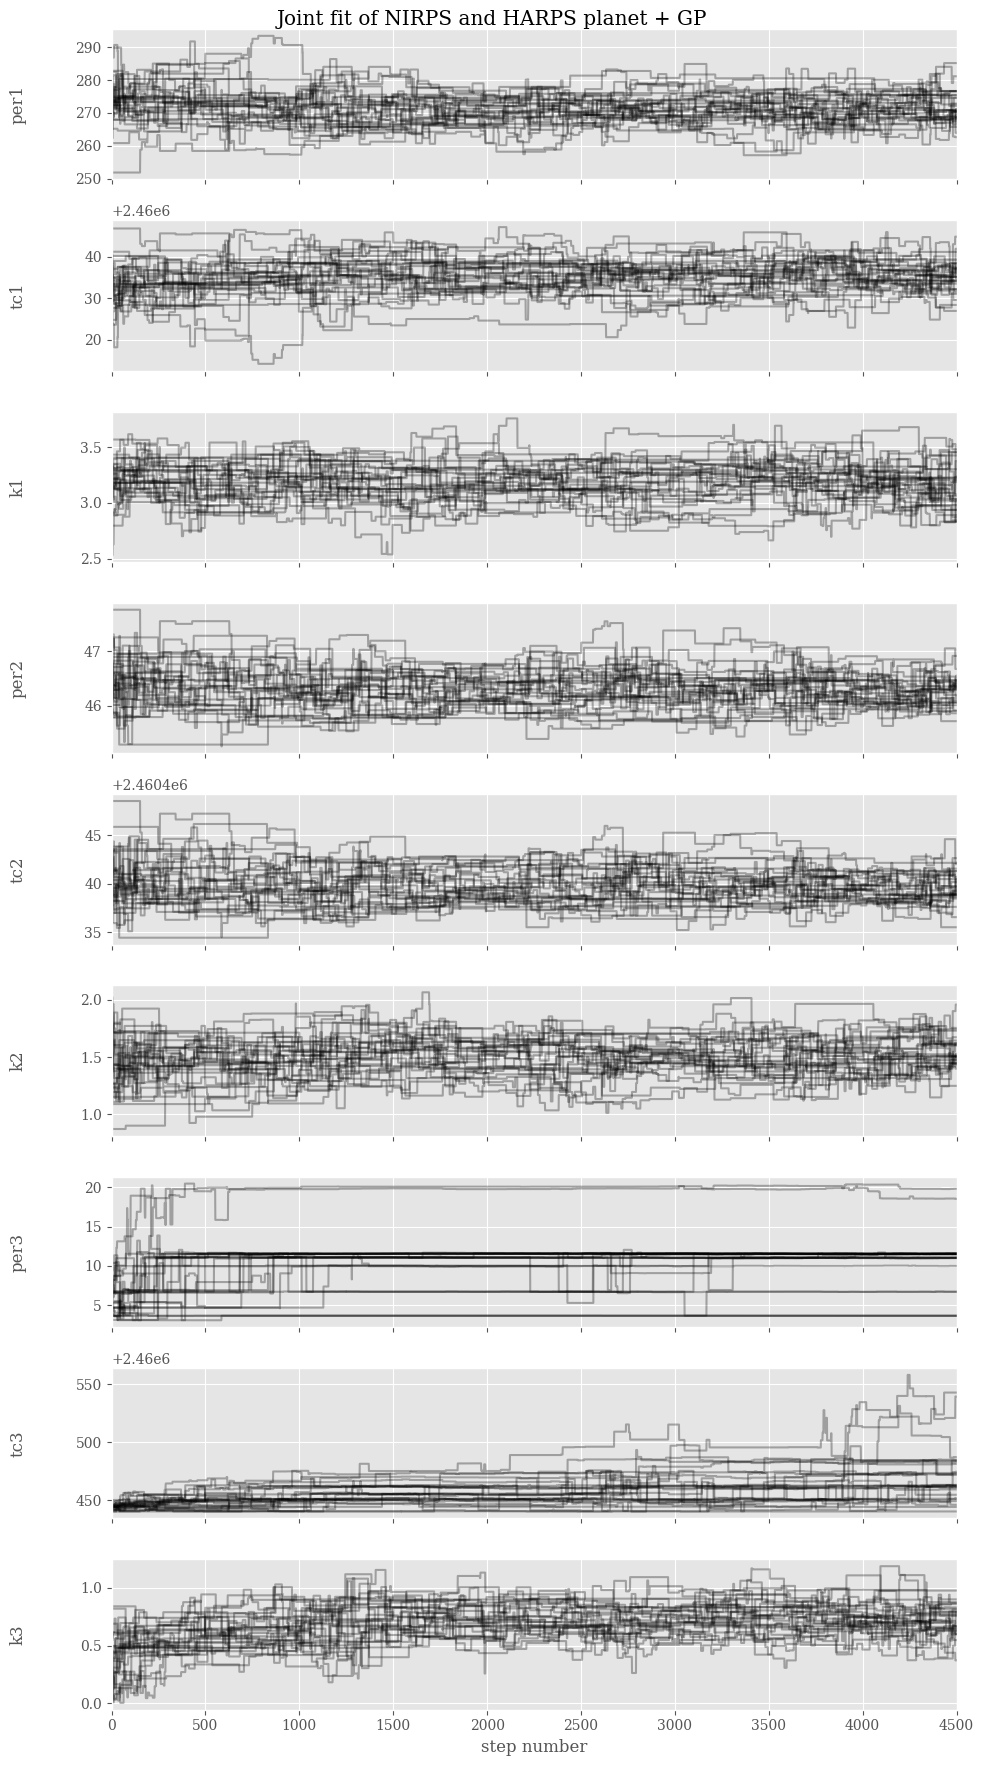

In [132]:
if data.sampler == 'emcee':  
    print('Plotting traceplot...')

    fig, axes = plt.subplots(ndim, figsize=(10, ndim*2), sharex=True)

    for i in range(ndim):
        ax = axes[i]
        ax.plot(post_samples_walkers[:,:, i], "k", alpha=0.3)
        ax.set_xlim(0, len(post_samples_walkers))
        ax.yaxis.set_label_coords(-0.1, 0.5)
        ax.set_ylabel(param_labels[i])
    axes[-1].set_xlabel("step number")
    plt.suptitle('Joint fit of NIRPS and HARPS planet + GP')
    plt.savefig(working_path + f'traceplot.png')

    print('Done.')

elif data.sampler == 'dynesty': 
    print('Plotting traceplot...')
    
    # Number of parameters
    ndim = len(comb_p0)

    # Create a figure for the trace plot
    fig, axes = plt.subplots(ndim + 1, 1, figsize=(10, 2 * (ndim + 1)), sharex=True)

    # Plot each parameter
    for i in range(ndim):
        axes[i].plot(post_samples[:, i], color='blue', alpha=0.5)
        axes[i].set_ylabel(param_labels[i])
        axes[i].grid(True)

    # Plot the log probability
    axes[ndim].plot(log_prob_samples, color='red', alpha=0.5)
    axes[ndim].set_ylabel('log_prob')
    axes[ndim].set_xlabel('Iteration')
    axes[ndim].grid(True)

    # Add a title to the figure
    fig.suptitle('Trace Plot', fontsize=16)

    # Adjust layout to avoid overlap
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    plt.savefig(working_path + f'traceplot.png')
    
    print('Done.')
    
else: 
    print('The selected sampler is not valid')

Cornerplot

Plotting corner plot...


Done.


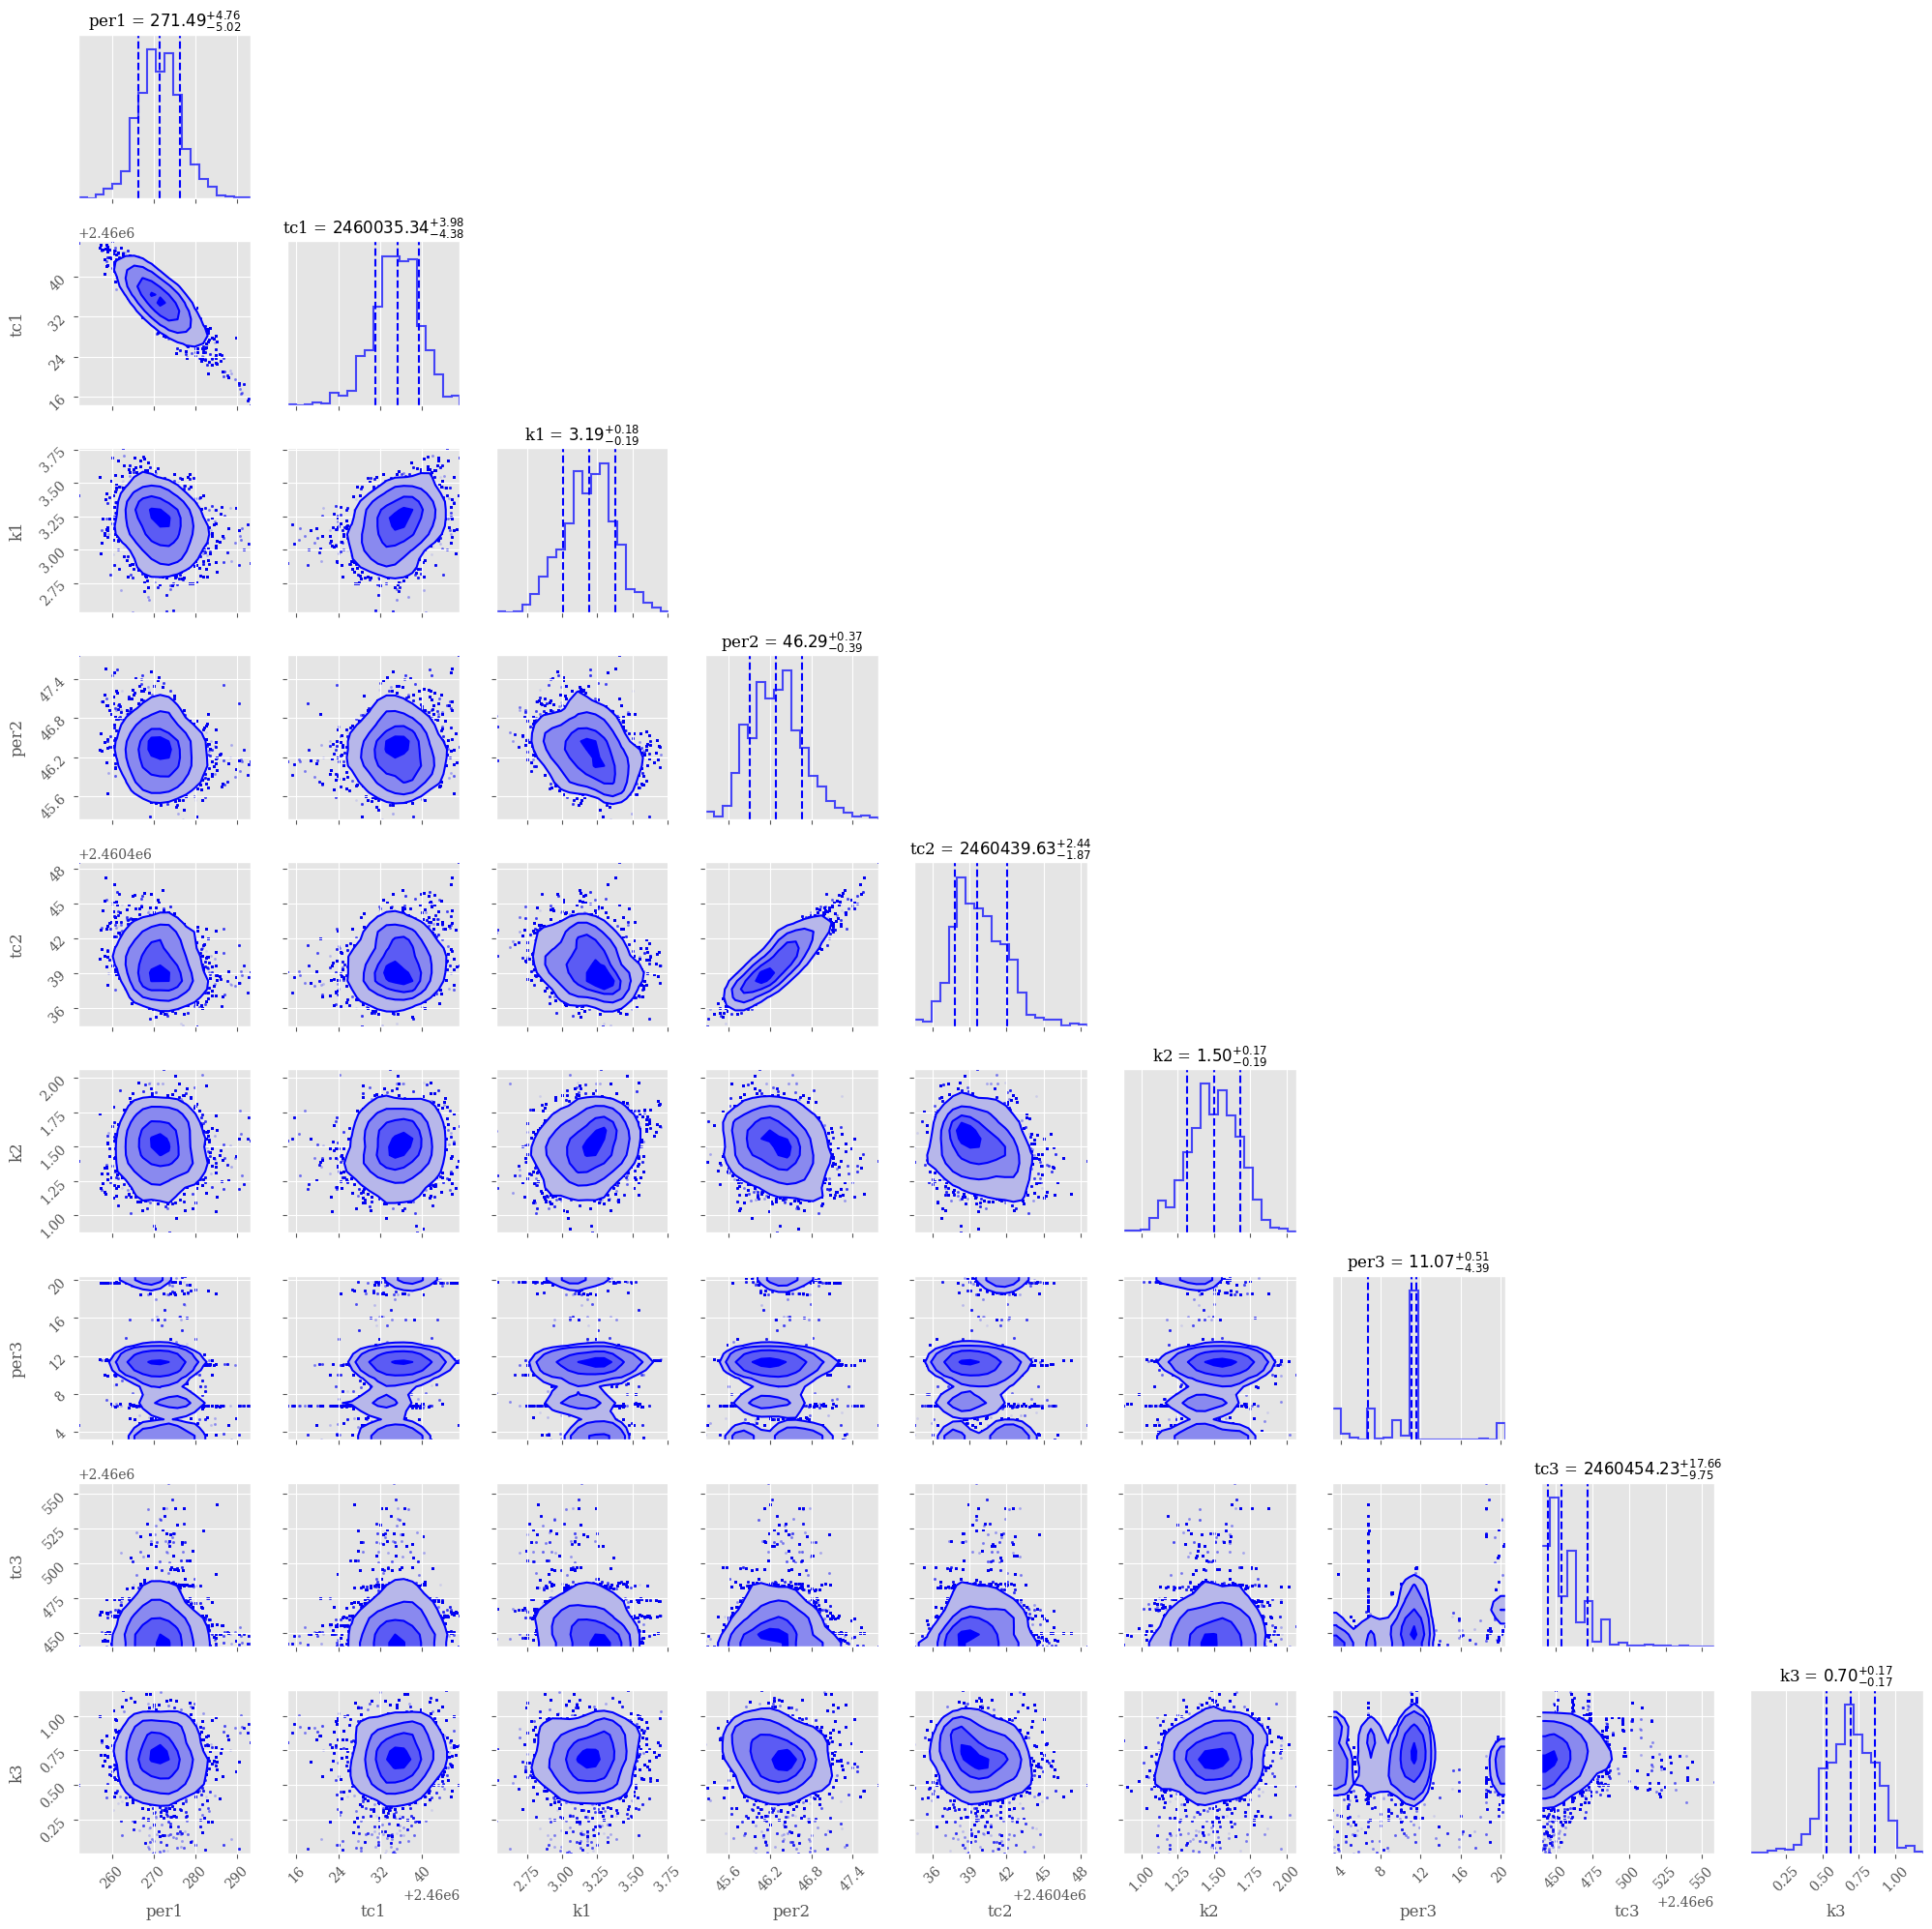

In [133]:
print('Plotting corner plot...')

# Make a corner plot
fig = corner.corner(
    post_samples,
    labels=param_labels,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    color="blue",  # Set a color scheme (optional)
    hist_kwargs={"linewidth": 1.5, "alpha": 0.7},  # Adjust histogram appearance
    fill_contours=True,  # Show contours for data density
    fill_kw={"cmap": "Blues"},  # Set colormap for contours (optional)
    smooth=True,  # Improve smoothness of contours
    fontsize=10,  # Set font size for labels and tick marks
    truth_color = 'orange',
)

plt.tight_layout()
plt.savefig(working_path + f'cornerplot.png')

print('Done.')

Best parameters

In [134]:
# Get the best parameters
med_params = np.median(post_samples.flatten().reshape(-1, ndim), axis=0)
max_params = rv.get_max_likelihood_params(post_samples.flatten().reshape(-1, ndim), log_prob_samples.flatten())

# Get the uncertainty
errors = np.percentile(post_samples.flatten().reshape(-1, ndim), [16, 84], axis=0)

print('Median likelihood parameters')
print('--------------------------')
# Show the median likelihood parameters
with open(working_path + 'median_likelihood_params.txt', 'w') as text_file:
    for i, label in enumerate(param_labels):
        print(f'{label}: {med_params[i]:.3f} - {errors[0][i]:.3f} + {errors[1][i]:.3f}')
        text_file.write(f'{label}: {med_params[i]:.3f} - {errors[0][i]:.3f} + {errors[1][i]:.3f}\n')
    
print('Maximum likelihood parameters')
print('--------------------------')
# Show the maximum likelihood parameters
with open(working_path + 'maximum_likelihood_params.txt', 'w') as text_file:
    for i, label in enumerate(param_labels):
        print(f'{label}: {max_params[i]:.3f} - {errors[0][i]:.3f} + {errors[1][i]:.3f}')
        text_file.write(f'{label}: {max_params[i]:.3f} - {errors[0][i]:.3f} + {errors[1][i]:.3f}\n')

Median likelihood parameters
--------------------------
per1: 271.492 - 266.476 + 276.250
tc1: 2460035.343 - 2460030.960 + 2460039.326
k1: 3.194 - 3.006 + 3.374
per2: 46.290 - 45.896 + 46.663
tc2: 2460439.631 - 2460437.763 + 2460442.075
k2: 1.504 - 1.316 + 1.678
per3: 11.066 - 6.678 + 11.575
tc3: 2460454.226 - 2460444.477 + 2460471.891
k3: 0.695 - 0.530 + 0.862
Maximum likelihood parameters
--------------------------
per1: 275.814 - 266.476 + 276.250
tc1: 2460033.197 - 2460030.960 + 2460039.326
k1: 3.249 - 3.006 + 3.374
per2: 46.460 - 45.896 + 46.663
tc2: 2460441.494 - 2460437.763 + 2460442.075
k2: 1.385 - 1.316 + 1.678
per3: 3.674 - 6.678 + 11.575
tc3: 2460444.113 - 2460444.477 + 2460471.891
k3: 0.755 - 0.530 + 0.862


Choose between median or maximum parameters

In [135]:
best_params = np.copy(max_params)
#best_params = np.copy(med_params)

Creating posterior samples

In [136]:
# Visualize posterior samples and max/median likelihood models
print('Creating posterior samples...')

num_display = 50
maxiter = 100
niter = 0

# Initialize dictionaries to store posterior samples for each instrument
model_post_samples = {instrument: [] for instrument in data.instruments}

while niter < maxiter and all(len(samples) < num_display for samples in model_post_samples.values()):
    n = np.random.randint(len(post_samples))
    
    try:
        model.update_params(post_samples[n])
        for instrument in data.instruments:
            model_post_samples[instrument].append(model.predict(data.t_mod[instrument]))
    except LinAlgError:
        print("LinAlgError")
        print(f"iteration {niter}")
        print("GP hyperparameters:")
        for instrument, gp_model in model.gp_models.items():
            pprint.pprint(gp_model.gp.get_parameter_dict())
    
    niter += 1

# Convert lists to numpy arrays
model_post_samples = {instrument: np.array(samples) for instrument, samples in model_post_samples.items()}

print('Done')

Creating posterior samples...
Done


Separate the best parameters between instruments

In [137]:
model.update_params(best_params)
noise_terms = {instrument: data.yerr_rv[instrument] for instrument in data.instruments}

Plot the best fit

Plotting the best-fit model and residuals


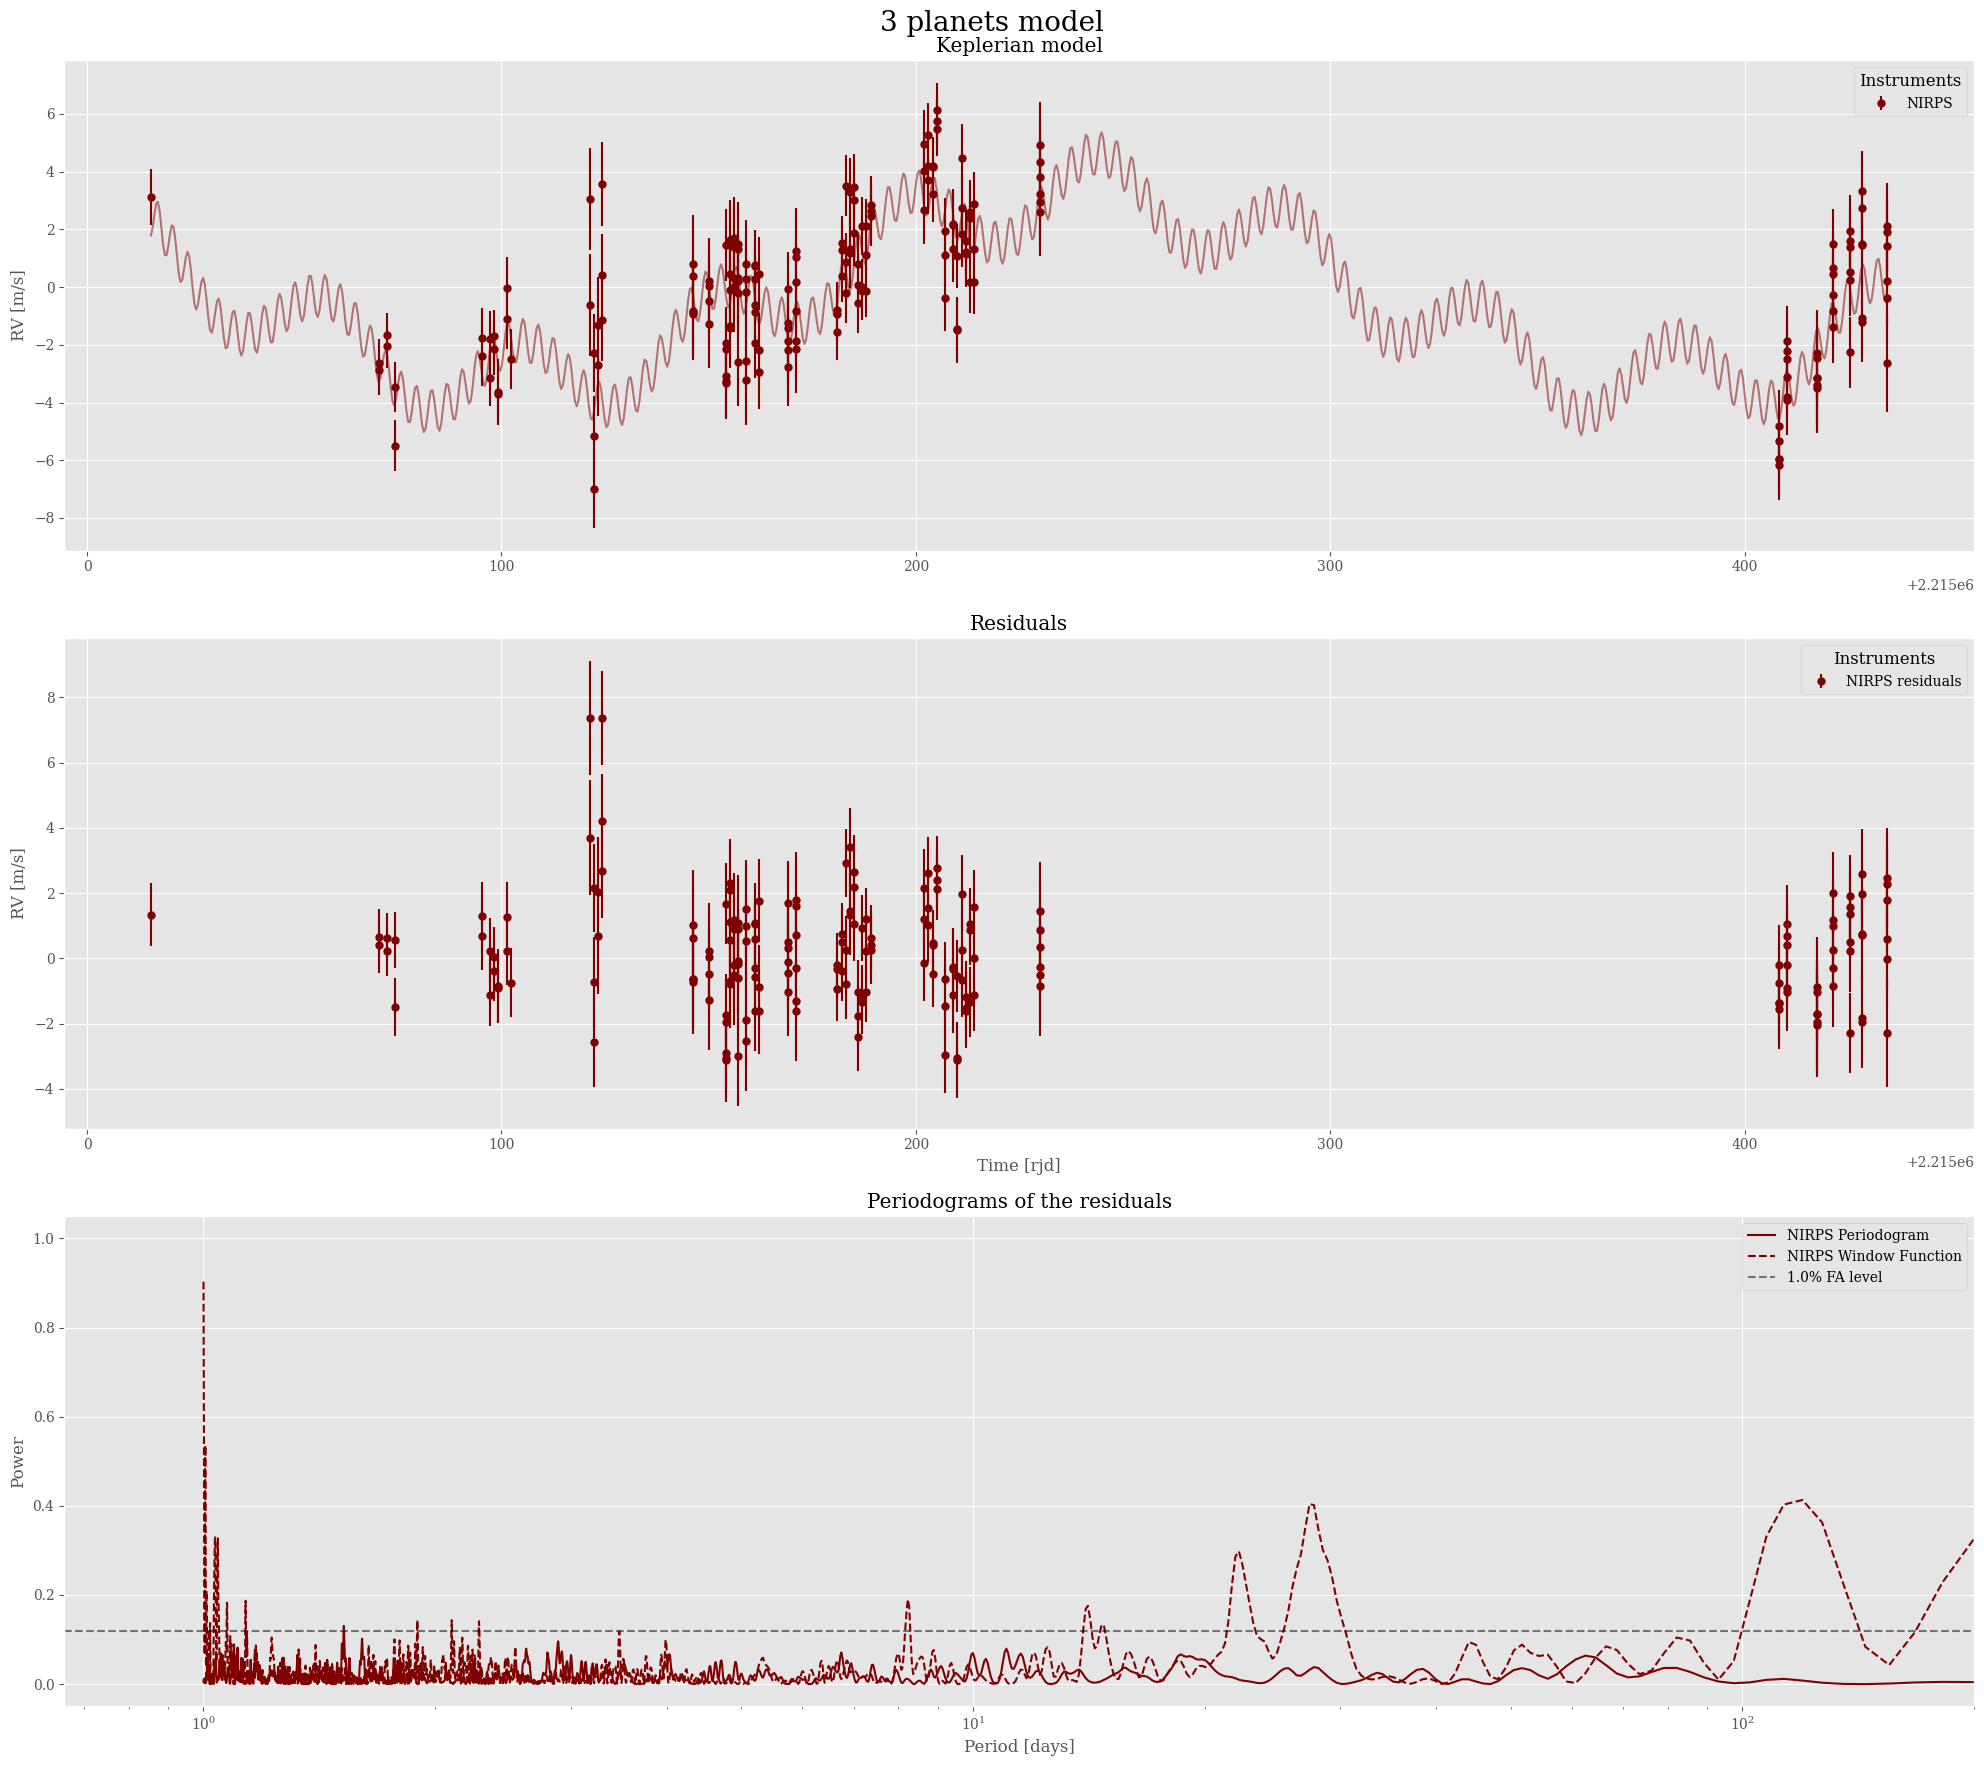

Done.


In [138]:
print('Plotting the best-fit model and residuals')

# Plot the planets + GP model and the samples
fig, axes = plt.subplots(3, 1, figsize=(20, 18), sharex=False)
rjd_off = 245000

# Dictionnaries to store the model predictions
planet_mod_pred_on_data = {}
planet_mod_pred_on_mod_times = {}


for idx, instrument in enumerate(data.instruments):
    planet_mod_pred_on_data[instrument] = model.predict(data.t_rv[instrument])
    planet_mod_pred_on_mod_times[instrument] = model.predict(data.t_mod[instrument])

    # Plot data with error bars
    axes[0].errorbar(data.t_rv[instrument] - rjd_off, data.y_rv[instrument] , yerr=noise_terms[instrument], fmt="o", ms=5, label=f'{instrument}', color=colors[idx])
    
    # Plot best likelihood
    axes[0].plot(data.t_mod[instrument] - rjd_off, planet_mod_pred_on_mod_times[instrument], color=colors[idx],
                 linewidth=1.5, alpha=0.5)  # Keplerian
    # Plot residuals
    axes[1].errorbar(data.t_rv[instrument] - rjd_off, data.y_rv[instrument] - planet_mod_pred_on_data[instrument], yerr=noise_terms[instrument], fmt='o', color=colors[idx], label=f'{instrument} residuals')
    
    # Plot the periodogram of the residuals
    ls = LombScargle(data.t_rv[instrument] - rjd_off, data.y_rv[instrument] - planet_mod_pred_on_data[instrument], dy=noise_terms[instrument])
    target_fap = 0.01
    fap = ls.false_alarm_level(target_fap)
    freq, power = ls.autopower(maximum_frequency=1.0)
    period = 1 / freq

    ls_window = LombScargle(data.t_rv[instrument] - rjd_off, np.ones_like(data.y_rv[instrument]), dy=noise_terms[instrument], fit_mean=False, center_data=False)
    power_window = ls_window.power(freq)

    axes[2].plot(period, power, color=colors[idx], label=f'{instrument} Periodogram')
    axes[2].plot(period, power_window, color=colors[idx], linestyle='--', label=f'{instrument} Window Function')

axes[2].axhline(fap, linestyle="--", color="black", label=f"{target_fap * 100}% FA level", alpha=0.5)

axes[0].set_title('Keplerian model')
axes[1].set_title('Residuals')
axes[2].set_title('Periodograms of the residuals')
axes[1].set_xlabel('Time [rjd]')
axes[0].set_ylabel('RV [m/s]')
axes[1].set_ylabel('RV [m/s]')
axes[0].legend(title='Instruments')
axes[1].legend(title='Instruments')
axes[2].set_xlabel('Period [days]')
axes[2].set_ylabel('Power')
axes[2].legend()
axes[2].set_xscale('log')
axes[2].set_xlim(0, 200)
plt.suptitle(f'{data.nplanets} planets model', fontsize=20)
plt.savefig(working_path + f'best_fit.png')
plt.show()

print('Done.')

Aliases to look out for
$$
\frac{1}{P_{\text{alias}}} = \left| \frac{1}{P} \pm \frac{1}{P_{\text{obs}}} \right| 

$$

In [139]:
# inst = 'AstroWiz'
# P_obs = (data.t_rv[inst][-1] - data.t_rv[inst][0]) / len(data.t_rv[inst])
# P = 100

# P_alias = 1 / np.abs(1 / P_obs - 1 / P)

# print('Alias period:', P_alias)

Analysis of the residuals

In [140]:
# Print the RMS of the residuals
rms = np.sqrt(np.mean([np.sum((np.abs(data.y_rv[instrument] - planet_mod_pred_on_data[instrument]))**2) for instrument in data.instruments]))
np.savetxt(working_path + 'rms.txt', np.array([rms]), fmt='%.6f')
print(f'RMS of the residuals: {rms:.3f} m/s')

# Print the median residual value
median_residual = np.median([np.median(np.abs(data.y_rv[instrument] - planet_mod_pred_on_data[instrument])) for instrument in data.instruments])
np.savetxt(working_path + 'median_residual.txt', np.array([median_residual]), fmt='%.6f')
print(f'Median residual value: {median_residual:.3f} m/s')

RMS of the residuals: 22.747 m/s
Median residual value: 1.035 m/s


Plotting the posterior samples

Plotting model samples
Done.


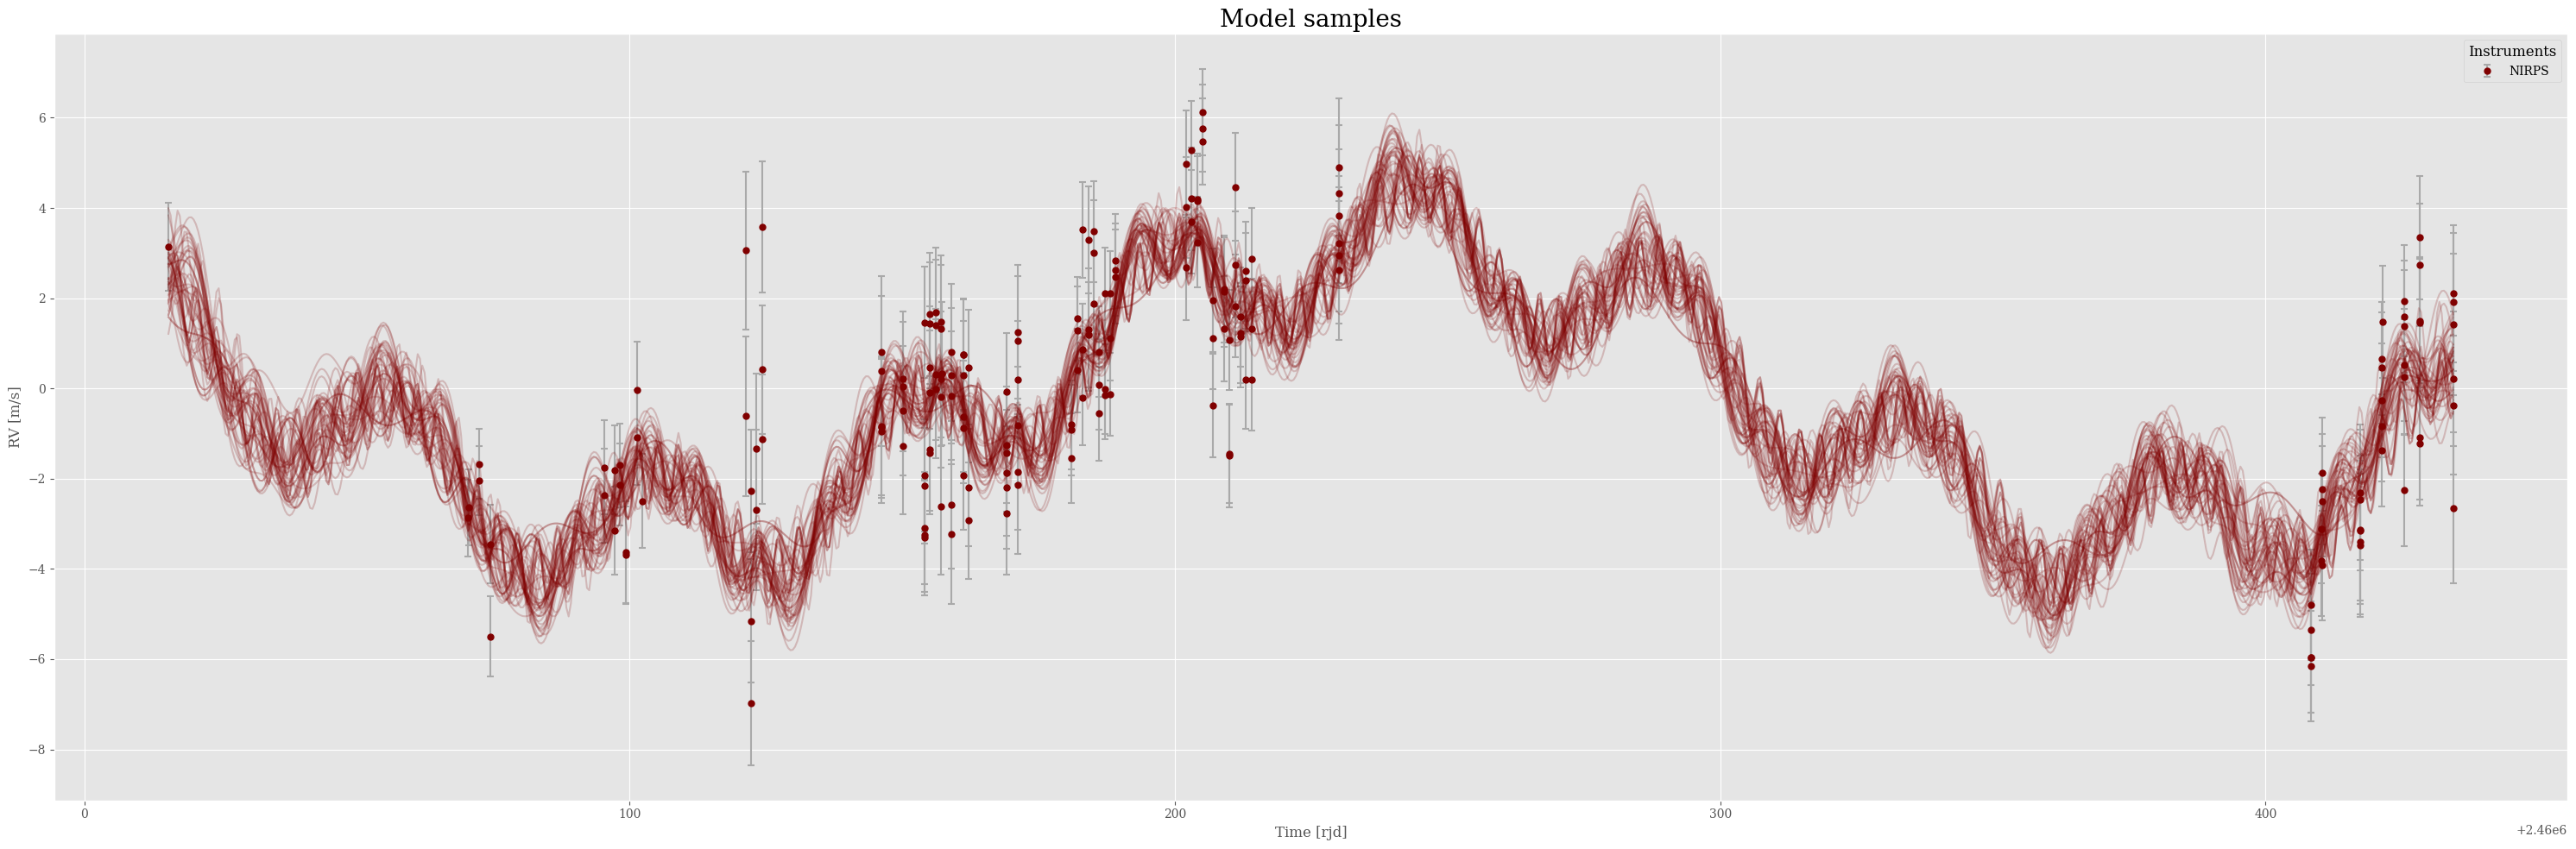

In [141]:
print('Plotting model samples')

fig, ax = plt.subplots(1, 1, figsize=(30, 10))

for idx, instrument in enumerate(data.instruments):
    ax.errorbar(data.t_rv[instrument], data.y_rv[instrument], yerr=noise_terms[instrument], fmt='o', 
                label=instrument, color=colors[idx], 
                ecolor='darkgray', elinewidth=1.5, capsize=3, capthick=1.5)
    ax.plot(data.t_mod[instrument], model_post_samples[instrument].T, alpha = 0.2, color = colors[idx])
    
ax.set_xlabel('Time [rjd]')
ax.set_ylabel('RV [m/s]')
ax.legend(title='Instruments')
ax.set_title('Model samples', fontsize = 20)

plt.savefig(working_path + f'planet_model_samples.png')
print('Done.')

Phase-folded plots

Plotting phase-folded RV curves of our planets...


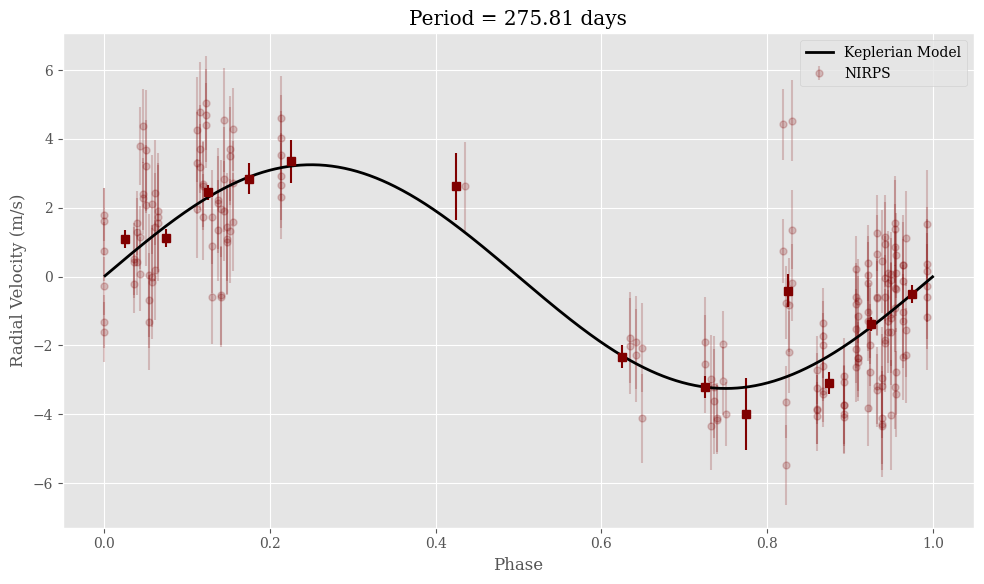

<Figure size 640x480 with 0 Axes>

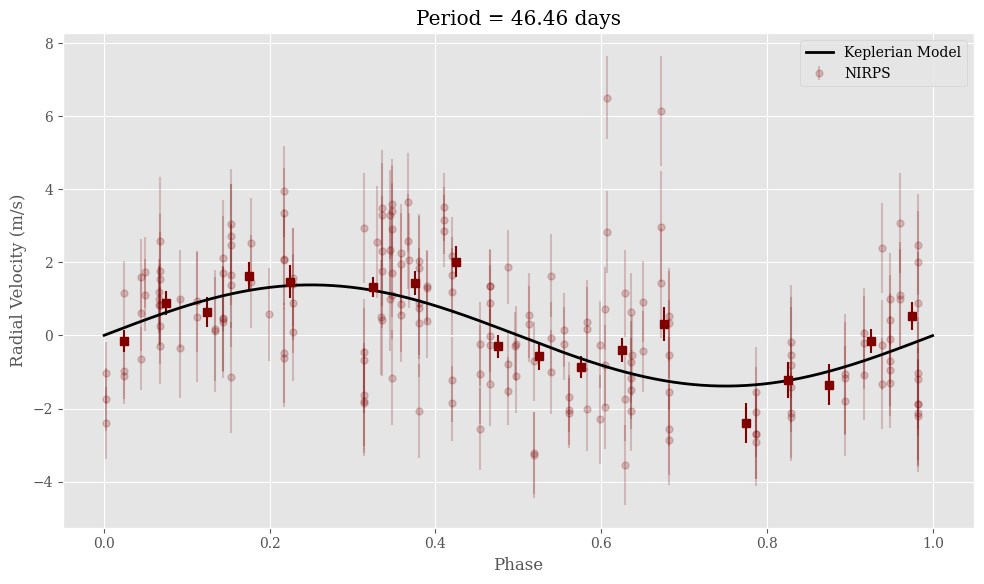

<Figure size 640x480 with 0 Axes>

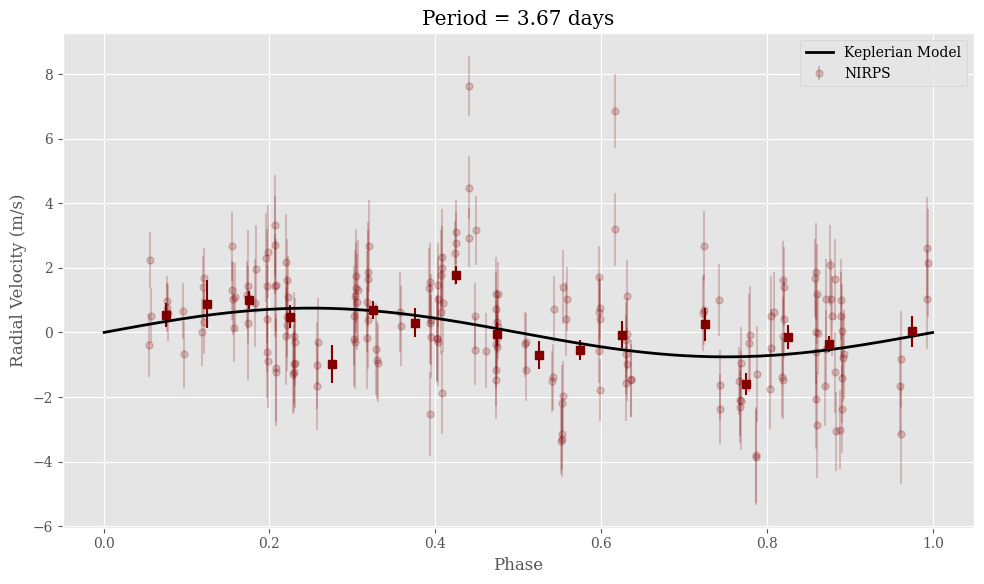

Done.


<Figure size 640x480 with 0 Axes>

In [142]:
print('Plotting phase-folded RV curves of our planets...')

def foldAt(time, period, t0):
    return ((time - t0 + 0.5 * period) % period) / period

def bin_data(phases, RVs, RV_errs, num_bins=20):
    bins = np.linspace(0, 1, num_bins + 1)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    binned_RVs = np.zeros(num_bins)
    binned_errs = np.zeros(num_bins)
    
    for i in range(num_bins):
        in_bin = (phases >= bins[i]) & (phases < bins[i+1])
        if np.any(in_bin):
            weights = 1 / RV_errs[in_bin]**2
            binned_RVs[i] = np.sum(RVs[in_bin] * weights) / np.sum(weights)
            binned_errs[i] = np.sqrt(1 / np.sum(weights))
        else:
            binned_RVs[i] = np.nan
            binned_errs[i] = np.nan
    
    return bin_centers, binned_RVs, binned_errs

def phase_folded_plot(data_times, model_times, RVs, RV_errs, keplerian_model_RVs, period, t0, instrument_names):
    
    # Plotting the data
    plt.figure(figsize=(10, 6))
    
    for i, instrument in enumerate(instrument_names):
        # Fold the data and model times to get the phases
        phases_data = foldAt(data_times[instrument], period, t0)
        phases_model = foldAt(model_times[instrument], period, t0)

        # Sort the phases for plotting
        sort_indices_data = np.argsort(phases_data)
        sort_indices_model = np.argsort(phases_model)

        phases_data_sorted = phases_data[sort_indices_data]
        RV_sorted = RVs[instrument][sort_indices_data]
        
        phases_model_sorted = phases_model[sort_indices_model]
        keplerian_model_RVs_sorted = keplerian_model_RVs[instrument][sort_indices_model]

        # Plot the observed data
        plt.errorbar(phases_data_sorted, RV_sorted, yerr=RV_errs[instrument], fmt='o', color=colors[i], label=f'{instrument}', zorder=1, alpha = 0.2)
        
        # Bin the data and plot the binned points
        bin_centers, binned_RVs, binned_errs = bin_data(phases_data_sorted, RV_sorted, RV_errs[instrument][sort_indices_data])
        plt.errorbar(bin_centers, binned_RVs, yerr=binned_errs, fmt='s', color=colors[i], zorder=2, markersize = 6)
    
    # Plot the model
    plt.plot(phases_model_sorted, keplerian_model_RVs_sorted, color='black', label='Keplerian Model', lw=2)

    # Add labels and title
    plt.xlabel('Phase')
    plt.ylabel('Radial Velocity (m/s)')
    plt.title(f'Period = {period:.2f} days')
    plt.legend()
    plt.grid(True)
    
    # Show the plot
    plt.show()

# Loop through each planet and plot the data
for idx_planet in range(model.num_planets):
    planet_params = radvel.Parameters(1, basis='per tc e w k')
    planet_params['per1'].value = best_params[data.n_planet_params*idx_planet]
    planet_params['tc1'].value  = best_params[data.n_planet_params*idx_planet+1]
    
    if data.n_planet_params == 5:
        planet_params['e1'].value = best_params[data.n_planet_params*idx_planet+2]
        planet_params['w1'].value = best_params[data.n_planet_params*idx_planet+3]
        planet_params['k1'].value  = best_params[data.n_planet_params*idx_planet+4]
    else:
        planet_params['e1'].value = 0.0
        planet_params['w1'].value = 1.57
        planet_params['k1'].value  = best_params[data.n_planet_params*idx_planet+2]

    # Create a Keplerian orbit model for the current planet
    radvel_model = radvel.RVModel(planet_params)

    data_times = {instrument: data.t_rv[instrument] for instrument in data.instruments}
    model_times = {instrument: data.t_mod[instrument] for instrument in data.instruments}
    
    # Subtract the GP model and other planets from the data
    RVs = {}
    for instrument in data.instruments:
        # Predict the RVs for the other planets
        other_planet_rvs = np.zeros_like(data.y_rv[instrument])
        for j in range(model.num_planets):
            if j != idx_planet:
                other_planet_params = radvel.Parameters(1, basis='per tc e w k')
                other_planet_params['per1'].value = best_params[data.n_planet_params*j]
                other_planet_params['tc1'].value = best_params[data.n_planet_params*j+1]
                if data.n_planet_params == 5:
                    other_planet_params['e1'].value = best_params[data.n_planet_params*j+2]
                    other_planet_params['w1'].value = best_params[data.n_planet_params*j+3]
                    other_planet_params['k1'].value = best_params[data.n_planet_params*j+4]
                else: 
                    other_planet_params['e1'].value = 0.0
                    other_planet_params['w1'].value = 1.57
                    other_planet_params['k1'].value = best_params[data.n_planet_params*j+2]
                
                other_planet_model = radvel.RVModel(other_planet_params)
                other_planet_rvs += other_planet_model(data.t_rv[instrument])

        RVs[instrument] = data.y_rv[instrument] - other_planet_rvs

    RV_errs = {instrument: data.yerr_rv[instrument] for instrument in data.instruments}
    keplerian_model_RVs = {instrument: radvel_model(data.t_mod[instrument]) for instrument in data.instruments}
    phase_folded_plot(data_times, model_times, RVs, RV_errs, keplerian_model_RVs, best_params[data.n_planet_params*idx_planet], best_params[data.n_planet_params*idx_planet+1], data.instruments)
    
    plt.savefig(working_path + f'phase_folded_planet_{idx_planet+1}.png')

print('Done.')

## Looking at the results in more details

### Histograms of the planets' parameters

In [143]:
def format_error(value, error):
    """
    Format the value and error to show all digits up to the first non-zero digit of the error.
    """
    error_str = f"{error:.2e}"
    decimal_places = abs(int(error_str.split('e')[-1]))
    format_str = f"{{:.{decimal_places}f}}"
    return format_str.format(value), format_str.format(error)

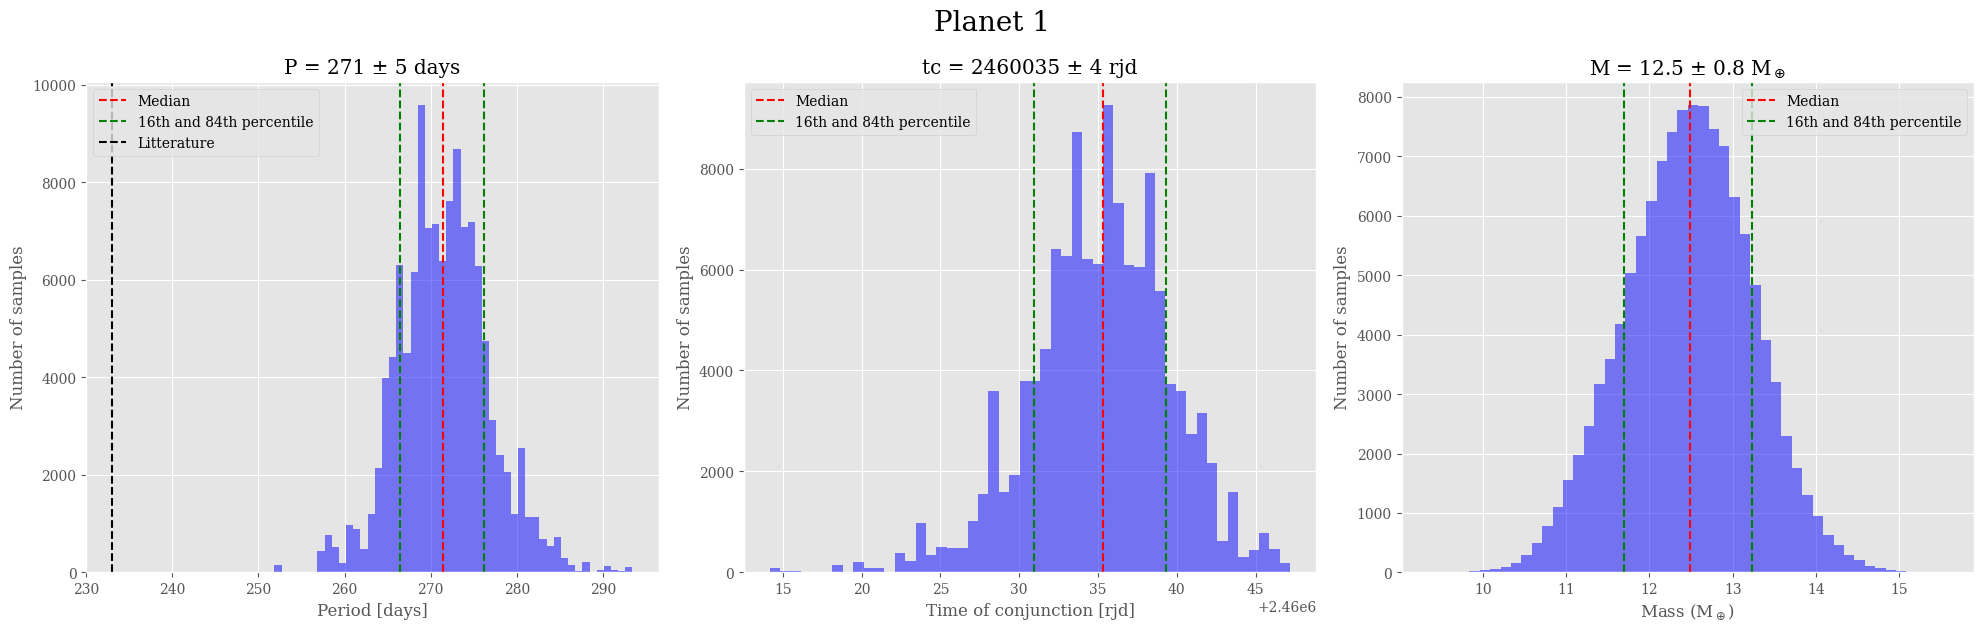

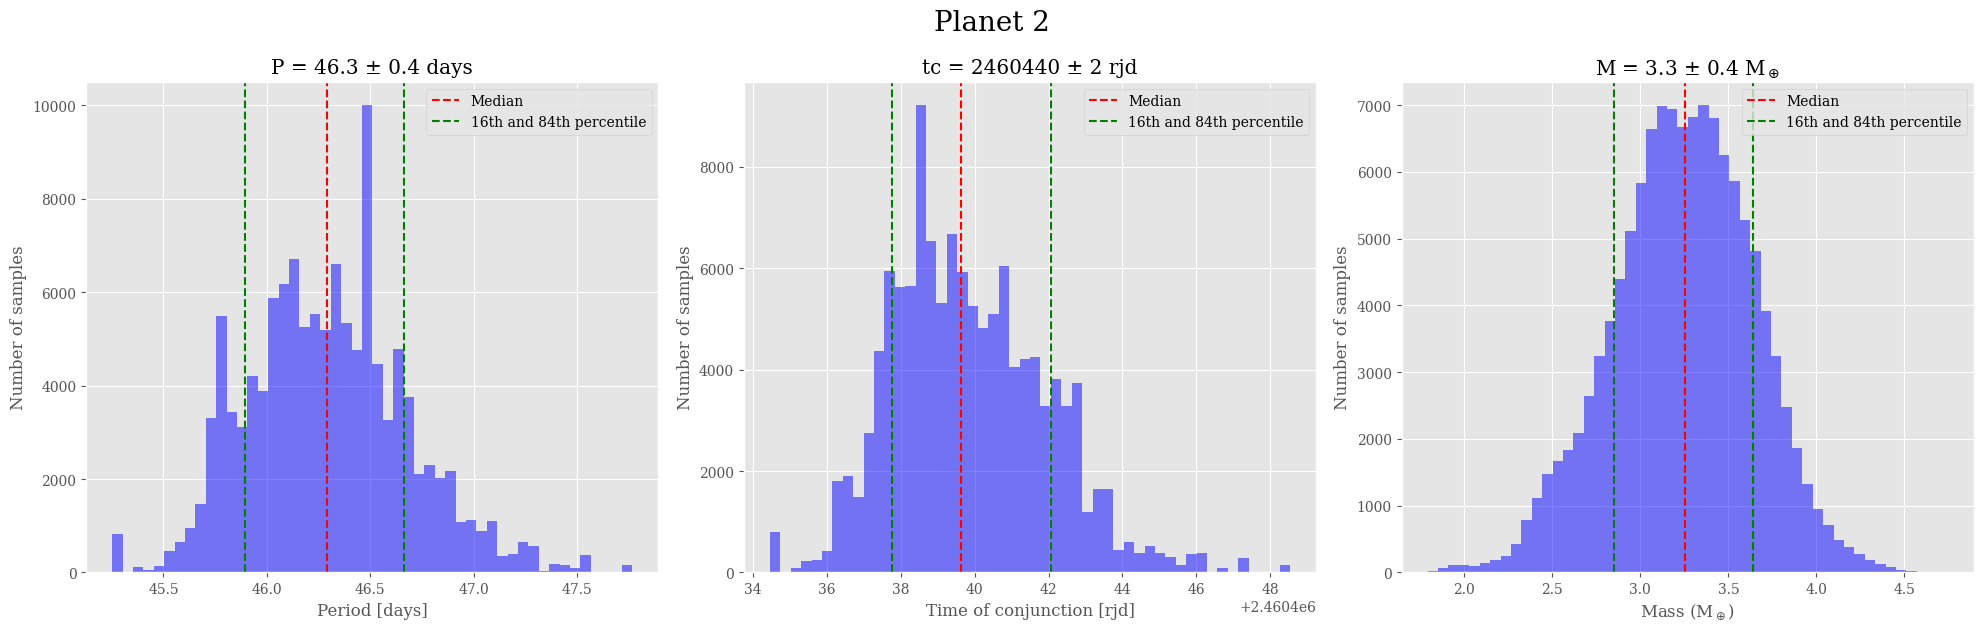

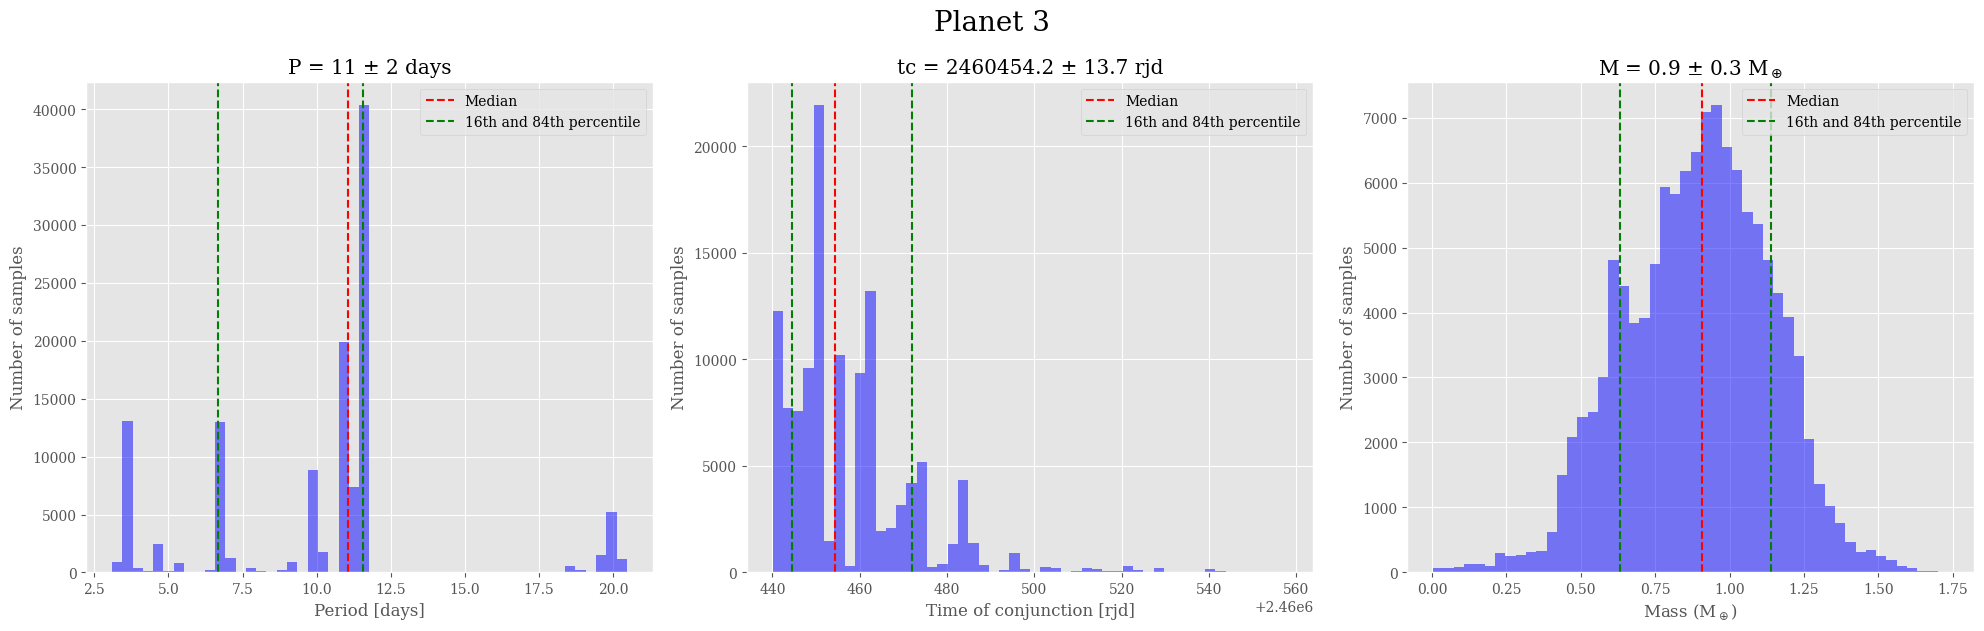

In [144]:
# Known info about the planets in the system
planets_info = data.star_info['planets']
letters = list(data.star_info['planets'].keys())


for p in range(data.nplanets):
    fig, axes = plt.subplots(1, data.n_planet_params, figsize=(20, 6))
    
    planet_number = p + 1
    
    # Litterature values
    per_lit = planets_info[letters[p]]['period']
    mass_lit = planets_info[letters[p]]['mass']
    ecc_lit = planets_info[letters[p]]['ecc']
    omega_lit = planets_info[letters[p]]['omega']
    
    # Period
    P_samples = post_samples[:, planet_number * data.n_planet_params - data.n_planet_params]
    P_med = np.median(P_samples)
    P_err = np.percentile(P_samples, [16, 84])
    P_med_str, P_err_str = format_error(P_med, np.mean(np.abs(P_err - P_med)))
    
    # Time of conjunction
    tc_samples = post_samples[:, planet_number * data.n_planet_params - data.n_planet_params + 1]
    tc_med = np.median(tc_samples)
    tc_err = np.percentile(tc_samples, [16, 84])
    tc_med_str, tc_err_str = format_error(tc_med, np.mean(np.abs(tc_err - tc_med)))


    if data.n_planet_params == 5:
        # Eccentricity
        e_samples = post_samples[:, planet_number * data.n_planet_params - data.n_planet_params + 2]
        e_med = np.median(e_samples)
        e_err = np.percentile(e_samples, [16, 84])
        e_med_str, e_err_str = format_error(e_med, np.mean(np.abs(e_err - e_med)))
        
        # Omega
        w_samples = post_samples[:, planet_number * data.n_planet_params - data.n_planet_params + 3]
        w_med = np.median(w_samples)
        w_err = np.percentile(w_samples, [16, 84])
        w_med_str, w_err_str = format_error(w_med, np.mean(np.abs(w_err - w_med)))
        
    
        k_samples = post_samples[:, planet_number * data.n_planet_params - data.n_planet_params + 4]
    else:
        k_samples = post_samples[:, planet_number * data.n_planet_params - data.n_planet_params + 2]
    
    # Mass    
    M_star = np.random.normal(data.data['star']['M_star'], data.data['star']['M_star_err'], len(k_samples))
    M_samples = radvel.utils.Msini(k_samples, P_samples, M_star, 0)  # Transform into mass 
    M_med = np.median(M_samples)
    M_err = np.percentile(M_samples, [16, 84])
    M_med_str, M_err_str = format_error(M_med, np.mean(np.abs(M_err - M_med)))
    
    # Period histogram
    axes[0].hist(P_samples, bins=50, color='blue', alpha=0.5)
    axes[0].set_xlabel('Period [days]')
    axes[0].set_ylabel('Number of samples')
    axes[0].axvline(P_med, color='red', linestyle='--', label='Median')
    axes[0].axvline(P_err[0], color='green', linestyle='--', label='16th and 84th percentile')
    axes[0].axvline(P_err[1], color='green', linestyle='--')
    axes[0].set_title(f'P = {P_med_str} ± {P_err_str} days')
    if per_lit != 'None': axes[0].axvline(per_lit, color='black', linestyle='--', label='Litterature')
    
    # Time of conjunction histogram
    axes[1].hist(tc_samples, bins=50, color='blue', alpha=0.5)
    axes[1].set_xlabel('Time of conjunction [rjd]')
    axes[1].set_ylabel('Number of samples')
    axes[1].axvline(tc_med, color='red', linestyle='--', label='Median')
    axes[1].axvline(tc_err[0], color='green', linestyle='--', label='16th and 84th percentile')
    axes[1].axvline(tc_err[1], color='green', linestyle='--')
    axes[1].set_title(f'tc = {tc_med_str} ± {tc_err_str} rjd')

    # Mass histogram
    axes[2].hist(M_samples, bins=50, color='blue', alpha=0.5)
    axes[2].set_xlabel('Mass (M$_\oplus$)')
    axes[2].set_ylabel('Number of samples')
    axes[2].axvline(M_med, color='red', linestyle='--', label='Median')
    axes[2].axvline(M_err[0], color='green', linestyle='--', label='16th and 84th percentile')
    axes[2].axvline(M_err[1], color='green', linestyle='--')
    axes[2].set_title(f'M = {M_med_str} ± {M_err_str} M$_\oplus$')
    if mass_lit != 'None': axes[2].axvline(mass_lit, color='black', linestyle='--', label='Litterature')
    
    
    axes[0].legend()
    axes[1].legend()
    axes[2].legend()
    
    if data.n_planet_params == 5:
        # Eccentricity histogram
        axes[3].hist(e_samples, bins=50, color='blue', alpha=0.5)
        axes[3].set_xlabel('Eccentricity')
        axes[3].set_ylabel('Number of samples')
        axes[3].set_title(f'e = {e_med_str} ± {e_err_str}')
        axes[3].axvline(e_med, color='red', linestyle='--', label='Median')
        axes[3].axvline(e_err[0], color='green', linestyle='--', label='16th and 84th percentile')
        axes[3].axvline(e_err[1], color='green', linestyle='--')
        if ecc_lit != 'None': axes[3].axvline(ecc_lit, color='black', linestyle='--', label='Litterature')
        axes[3].legend()
        
        # Omega histogram
        axes[4].hist(w_samples, bins=50, color='blue', alpha=0.5)
        axes[4].set_xlabel(r'$\omega$ (radians)')
        axes[4].set_ylabel('Number of samples')
        axes[4].set_title(f'$\omega$ = {w_med_str} ± {w_err_str}')
        axes[4].axvline(w_med, color='red', linestyle='--', label='Median')
        axes[4].axvline(w_err[0], color='green', linestyle='--', label='16th and 84th percentile')
        axes[4].axvline(w_err[1], color='green', linestyle='--')
        if omega_lit != 'None': axes[4].axvline(omega_lit, color='black', linestyle='--', label='Litterature')
        axes[4].legend()
        
    plt.tight_layout()
    plt.suptitle(f'Planet {planet_number}', fontsize=20, y=1.05)
    plt.savefig(working_path + f'planet_{planet_number}_histogram.png')


In [145]:
print('All done! Hope you will be happy with your results')

All done! Hope you will be happy with your results


Done!